In [15]:
import numpy as np
import cv2
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.neighbors import KernelDensity
from networkx.algorithms.flow import maximum_flow
from tqdm import tqdm
from networkx.algorithms.flow import edmonds_karp
from scipy.stats import gaussian_kde


In [16]:
def bpq(ip, iq, sigma):
    
    return np.exp(-((np.linalg.norm(ip - iq)) ** 2) / (2 * sigma ** 2))

In [17]:
def find_min_cut(G,  sink,source):

    def residual_capacity(u, v):
        return G[u][v].get('capacity', 0) - G[u][v].get('flow', 0)

    def bfs(G, source, sink, parent):
        visited = set()
        queue = []
        queue.append(source)
        visited.add(source)

        while queue:
            u = queue.pop(0)

            for v in G.successors(u):
                if v not in visited and residual_capacity(u, v) > 0:
                    queue.append(v)
                    visited.add(v)
                    parent[v] = u

        return visited

    parent = {}
    max_flow = 0

    while bfs(G, source, sink, parent):
        path_flow = float('inf')
        s = sink
        while s != source:
            path_flow = min(path_flow, residual_capacity(parent[s], s))
            s = parent[s]

        max_flow += path_flow

        v = sink
        while v != source:
            u = parent[v]
            flow_in = G[u][v].get('flow', 0)
            flow_out = G[v][u].get('flow', 0)
            G[u][v]['flow'] = flow_in + path_flow  # Update flow on forward edge
            G[v][u]['flow'] -= flow_out - path_flow  # Update flow on reverse edge (if it exists)
            v = u

    # Identify the minimum cut based on residual capacities
    reachable_nodes = bfs(G, source, sink, parent)  # Nodes reachable from source
    cut_nodes = list(set(G.nodes) - reachable_nodes)  # Remaining nodes

    return reachable_nodes, cut_nodes


In [18]:
def segment_image(img, fg_points, bg_points, sigma=0.7, lamda=1):
    # Create a directed graph
    g = nx.DiGraph()
    
    h, w, _ = img.shape
    nodeids = [(i, j) for i in range(h) for j in range(w)]
    g.add_nodes_from(nodeids)
    
    # Add edges between neighboring pixels with weights based on similarity
    for i in range(h):
        for j in range(w):
            if j > 0:
                
                g.add_edge((i, j), (i, j - 1), capacity=bpq(img[i, j], img[i, j - 1], sigma))
            if i > 0:
                
                g.add_edge((i, j), (i - 1, j), capacity=bpq(img[i, j], img[i - 1, j], sigma))

    # Add source and sink nodes
    source_node = (-1, -1)  # Source node
    sink_node = (-2, -2)    # Sink node
    g.add_node(source_node)
    g.add_node(sink_node)
    
    import numpy as np

    def intensity_distribution(image,pixel_coords):
        # Extract intensity values from pixel coordinates
        def get_intensity(coord):
            return image[coord[0], coord[1]]
        intensity_values = [get_intensity(coord) for coord in pixel_coords]

        # Create KDE of intensity values
        intensity_values_split = list(zip(*intensity_values))


        kder = gaussian_kde(intensity_values_split[0])
        kdeg = gaussian_kde(intensity_values_split[1])
        kdeb = gaussian_kde(intensity_values_split[2])
        
        # Function to get intensity value of a pixel
        
        plus=0.000001
        # Function to calculate probability for another pixel
        def probability_for_pixel(other_coord):
            intensity = get_intensity(other_coord)
            return (kder.evaluate(intensity[0])[0]+plus)*(kdeb.evaluate(intensity[1])[0]+plus)*(kdeb.evaluate(intensity[2])[0]+plus)

        return probability_for_pixel


    probability_function_fg = intensity_distribution(img,fg_points)
    probability_function_bg = intensity_distribution(img,bg_points)
    
    # Add edges from source node to non-scribbled pixels
    for node in nodeids:
        if node not in fg_points and  node not in bg_points:
            g.add_edge(source_node, node, capacity=probability_function_fg(node))
            g.add_edge(node, sink_node, capacity=probability_function_bg(node))

    # Add edges from foreground points to source and sink nodes
    for fg_p in fg_points:
        g.add_edge(source_node, fg_p, capacity=float(1))
        g.add_edge(fg_p, sink_node, capacity=float(0))

    
    # Add edges from background points to source and sink nodes
    for bg_p in bg_points:
        g.add_edge(source_node, bg_p, capacity=float(0))
        g.add_edge(bg_p, sink_node, capacity=float(1))
    

    cut_value, partition = nx.minimum_cut(g, (-1, -1), (-2, -2))


    return list(partition[0]), list(partition[1])


In [19]:
def draw_segment(event, x, y, flags, param):
    global drawing, prev_point, fg_points, bg_points, img_display
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        prev_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            if flags & cv2.EVENT_FLAG_CTRLKEY:
                cv2.line(img_display, prev_point, (x, y), (0, 255, 0), thickness=5)  # Draw green line for background
                bg_points.append((y, x))  # Add point to background points
            else:
                cv2.line(img_display, prev_point, (x, y), (0, 0, 255), thickness=5)  # Draw red line for foreground
                fg_points.append((y, x))  # Add point to foreground points
            prev_point = (x, y)
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False

Processing...


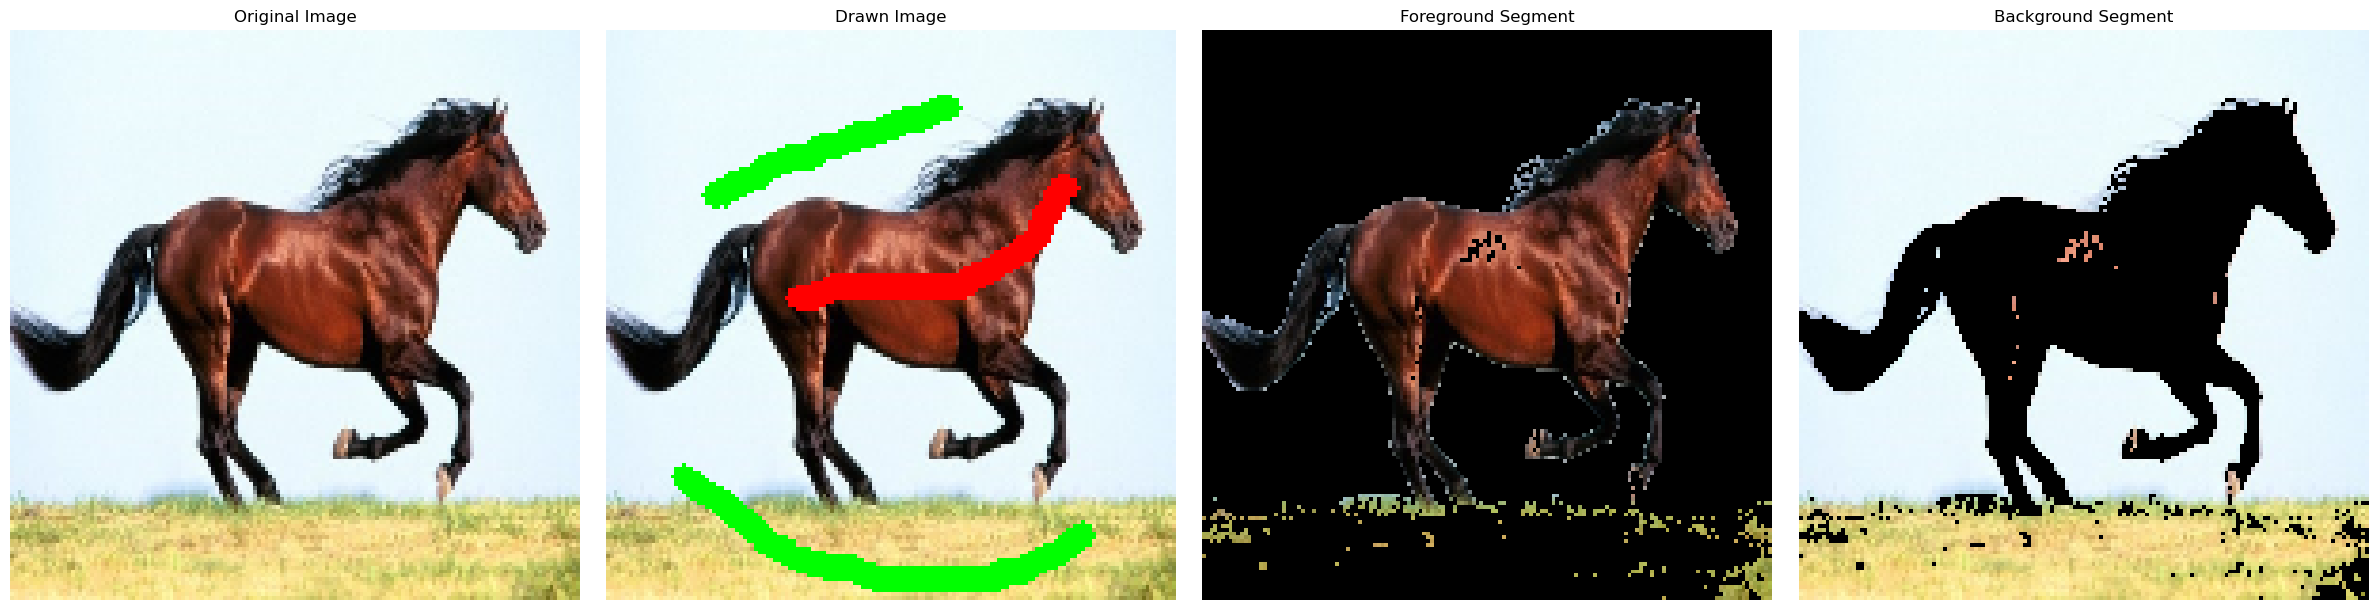

In [22]:
# Load the image
img = cv2.imread("horse.jpg")

img=cv2.resize(img,(150,150))
img_display = img.copy()  

cv2.namedWindow("Draw Foreground and Background Segments")
cv2.setMouseCallback("Draw Foreground and Background Segments", draw_segment)

drawing = False
prev_point = None
fg_points = []
bg_points = []


cv2.namedWindow("Draw Foreground and Background Segments")
cv2.setMouseCallback("Draw Foreground and Background Segments", draw_segment)

# Main loop
while True:
    cv2.imshow("Draw Foreground and Background Segments", img_display)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("s"):
        # Segment the image
        print('Processing...')
        fg_segment, bg_segment = segment_image(img, fg_points, bg_points)
        # Create blank images with the same dimensions as the original image
        foreground_img = np.zeros_like(img)
        background_img = np.zeros_like(img)
        foreground_img.fill(0)
        background_img.fill(0)
        # Get the dimensions of the original image
        height, width, _ = img.shape


        # Construct the foreground segment image
        for coord in fg_segment:
            x, y = coord
            foreground_img[x, y] = img[x, y]

        # Construct the background segment image
        for coord in bg_segment:
            x, y = coord
            background_img[x, y] = img[x, y]

        fig, axes = plt.subplots(1, 4, figsize=(24, 6))

        # Original image
        axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        # Foreground segment
        axes[2].imshow(cv2.cvtColor(foreground_img, cv2.COLOR_BGR2RGB))
        axes[2].set_title("Foreground Segment")
        axes[2].axis('off')

        # Background segment
        axes[3].imshow(cv2.cvtColor(background_img, cv2.COLOR_BGR2RGB))
        axes[3].set_title("Background Segment")
        axes[3].axis('off')

        # Drawn image
        axes[1].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
        axes[1].set_title("Drawn Image")
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

    elif key == ord("q"):
        break

cv2.destroyAllWindows()